In [6]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

In [50]:
N = 1000
size = 64
labels = np.random.randint(1, size = N)
imgs = np.zeros((size, size, N))




In [51]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_new_blob_img(ellipse=True, size=size,num_big_blobs=4)
    elif labels[i] == 1:
        x = generator.generate_new_blob_img(ellipse=False, size=size,num_big_blobs=4)
    elif labels[i] == 2:
        x = generator.generate_new_blob_img(ellipse=False, size=size,num_big_blobs=0)
    imgs[:,:,i] = x

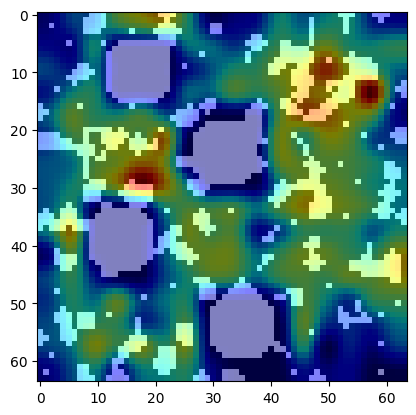

In [57]:
model = tf.keras.models.load_model("models/model40_padding")
plt.imshow(imgs[:,:,2], cmap = 'gray')
plt.imshow(GradCam(imgs[:,:,2], model, -6, 0), cmap ='jet', alpha = 0.5)

In [58]:
#make gradcam heatmap for every image and normalise
heatmaps = np.zeros_like(imgs)
model = tf.keras.models.load_model("models/model40_padding/")

for img in range(N):
    heatmaps[:,:,img] = GradCam(imgs[:,:,img], model, -6, 0)
    heatmaps[:,:,img] /= 255
    #heatmaps[:,:,img] = minmax_scale(heatmaps[:,:,img])



In [59]:
#get segmentation for every image
region_imgs = np.zeros_like(imgs, dtype=np.int64)

for img in range(N):
    region_imgs[:,:,img] = measure.label(imgs[:,:,img])

In [60]:
#find number of blobs in all images
num_blobs_array = []
for img in range(N):
    num_blobs_array.append(np.unique(region_imgs[:,:,img]).shape[0] - 1)

num_blobs = sum(num_blobs_array)
num_blobs

73415

In [61]:
num_blobs//imgs.shape[-1]

73

In [62]:
#generate interpretability scores for each blob; score is the sum of intensities of heatmap in the region
#plus get the highest score for every image
scores = np.zeros(num_blobs)
i = 0
highscores = []
for img in range(N):
    img_highscore = 0
    for region in np.unique(region_imgs[:,:,img]):   
        if region != 0:
            x = np.copy(region_imgs[:,:,img])
            x[x != region] = 0
            x[x == region] = 1
            img_score = heatmaps[:,:,img] * x
            scores[i] = np.mean(img_score[img_score!=0])
            if scores[i] > img_highscore:
                img_highscore = scores[i]
            i += 1
    highscores.append(img_highscore)
        

C:\Users\William\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

C:\Users\William\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



In [63]:
scores = np.nan_to_num(scores, nan=0)


In [64]:
highscores = np.asarray(highscores)
ind = np.where(np.in1d(scores, highscores))[0]
ind.shape

(3196,)

In [65]:
blob_areas = []
blob_eccentricities = []
blob_eq_areas = []
for img in range(N):
    areas = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['area'])).to_numpy().squeeze()
    eccentricities = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['eccentricity'])).to_numpy().squeeze()
    eq_areas = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['equivalent_diameter_area'])).to_numpy().squeeze()
    blob_areas += areas.tolist()
    blob_eccentricities += eccentricities.tolist()
    blob_eq_areas += eq_areas.tolist()

blob_areas = np.asarray(blob_areas)
blob_eccentricities = np.asarray(blob_eccentricities)
blob_eq_areas = np.asarray(blob_eq_areas)
blob_areas.shape

(73415,)

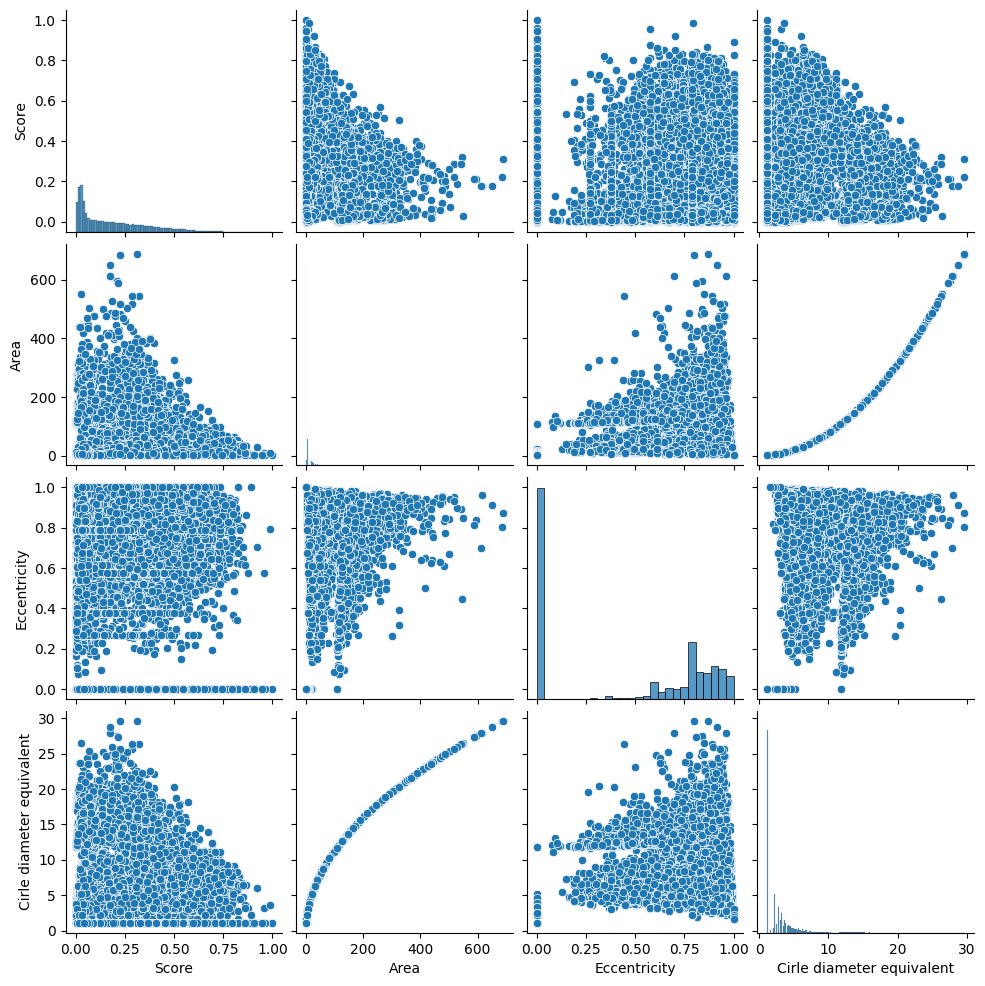

In [66]:
from seaborn import pairplot
data = pd.DataFrame({'Score': scores, 
                        'Area': blob_areas,
                        'Eccentricity': blob_eccentricities,
                        'Cirle diameter equivalent': blob_eq_areas})

pairplot(data)


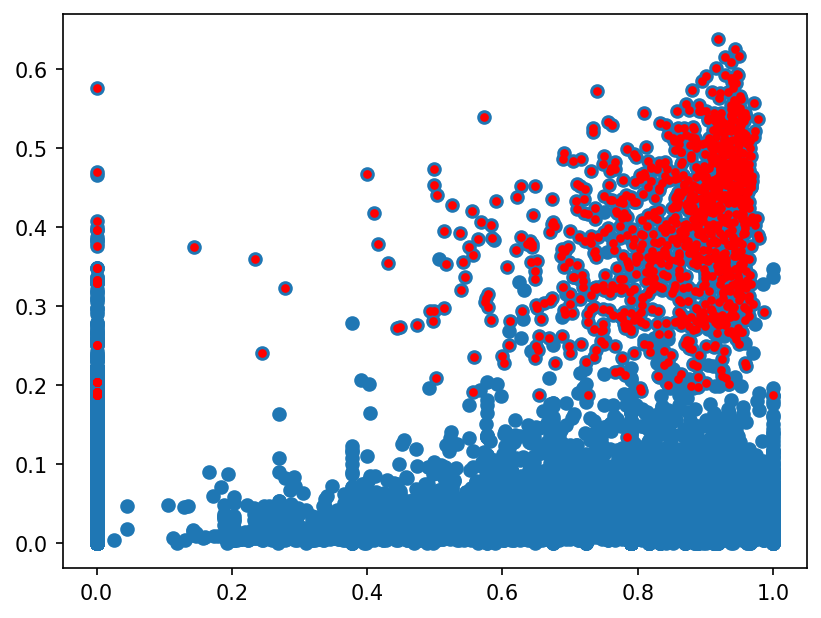

In [27]:
y = scores[ind]
x = blob_eccentricities[ind]
fig= plt.figure()
fig.set_dpi(150)
plt.scatter(blob_eccentricities, scores)
plt.scatter(x,y, s = 10, c = 'r')

0.030289527369802765

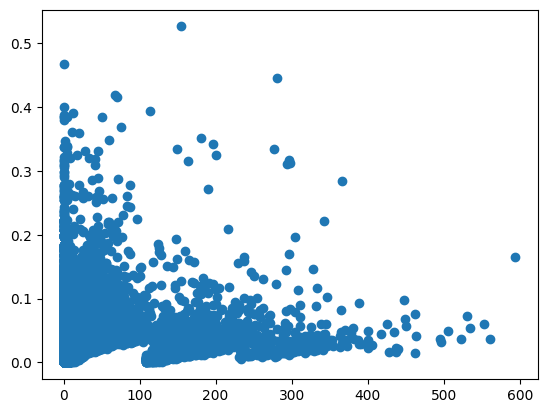

In [28]:
fig = plt.figure()
plt.scatter(np.delete(blob_areas, ind), np.delete(scores, ind))
np.mean(np.delete(scores, ind))

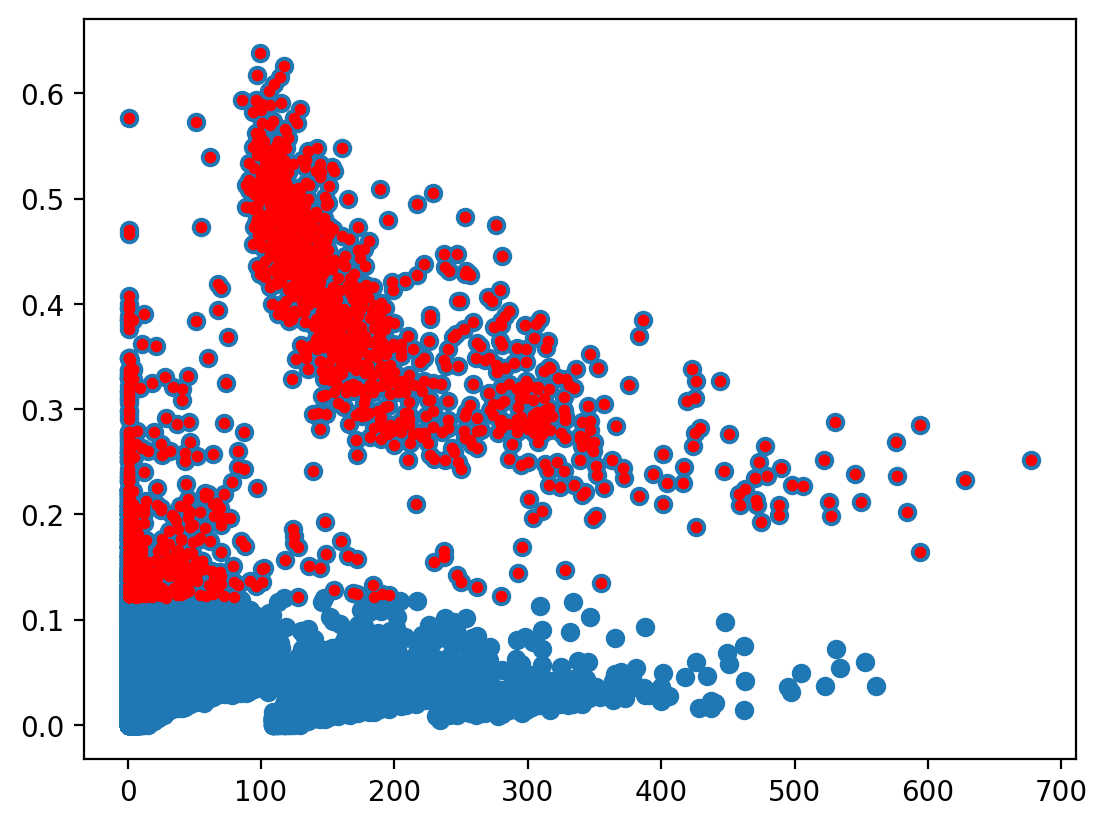

In [29]:
quant = np.quantile(scores, 1 - 1/40)
z = np.where(scores > quant)[0]
y = scores[z]
x = blob_areas[z]
fig = plt.figure()
fig.set_dpi(200)
plt.scatter(blob_areas, scores)
plt.scatter(x,y, s = 10,  c='r')

In [30]:
import plotly
import plotly.express as px

df = pd.DataFrame(data=np.vstack((blob_eccentricities, scores)).T, columns=['area', ' score'])
px.scatter(data_frame=df, x = df.columns[0], y = df.columns[1])


C:\Users\William\AppData\Local\Temp\1\ipykernel_4632\2958983600.py:6: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



Text(0.5, 0, 'Score')

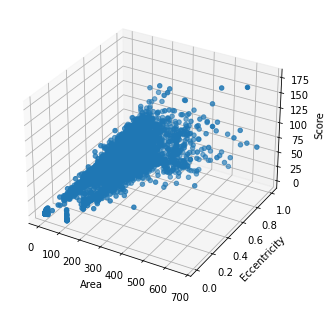

In [144]:
from mpl_toolkits.mplot3d import Axes3D
x = blob_areas
y = blob_eccentricities
z = scores
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x,y,z)

ax.set_xlabel('Area')
ax.set_ylabel('Eccentricity')
ax.set_zlabel('Score')

In [67]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.vstack((blob_eccentricities, blob_areas))
X = np.transpose(X)
y = scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)





In [68]:
#build regression tree
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=3)
regressor = regressor.fit(X_train, y_train)

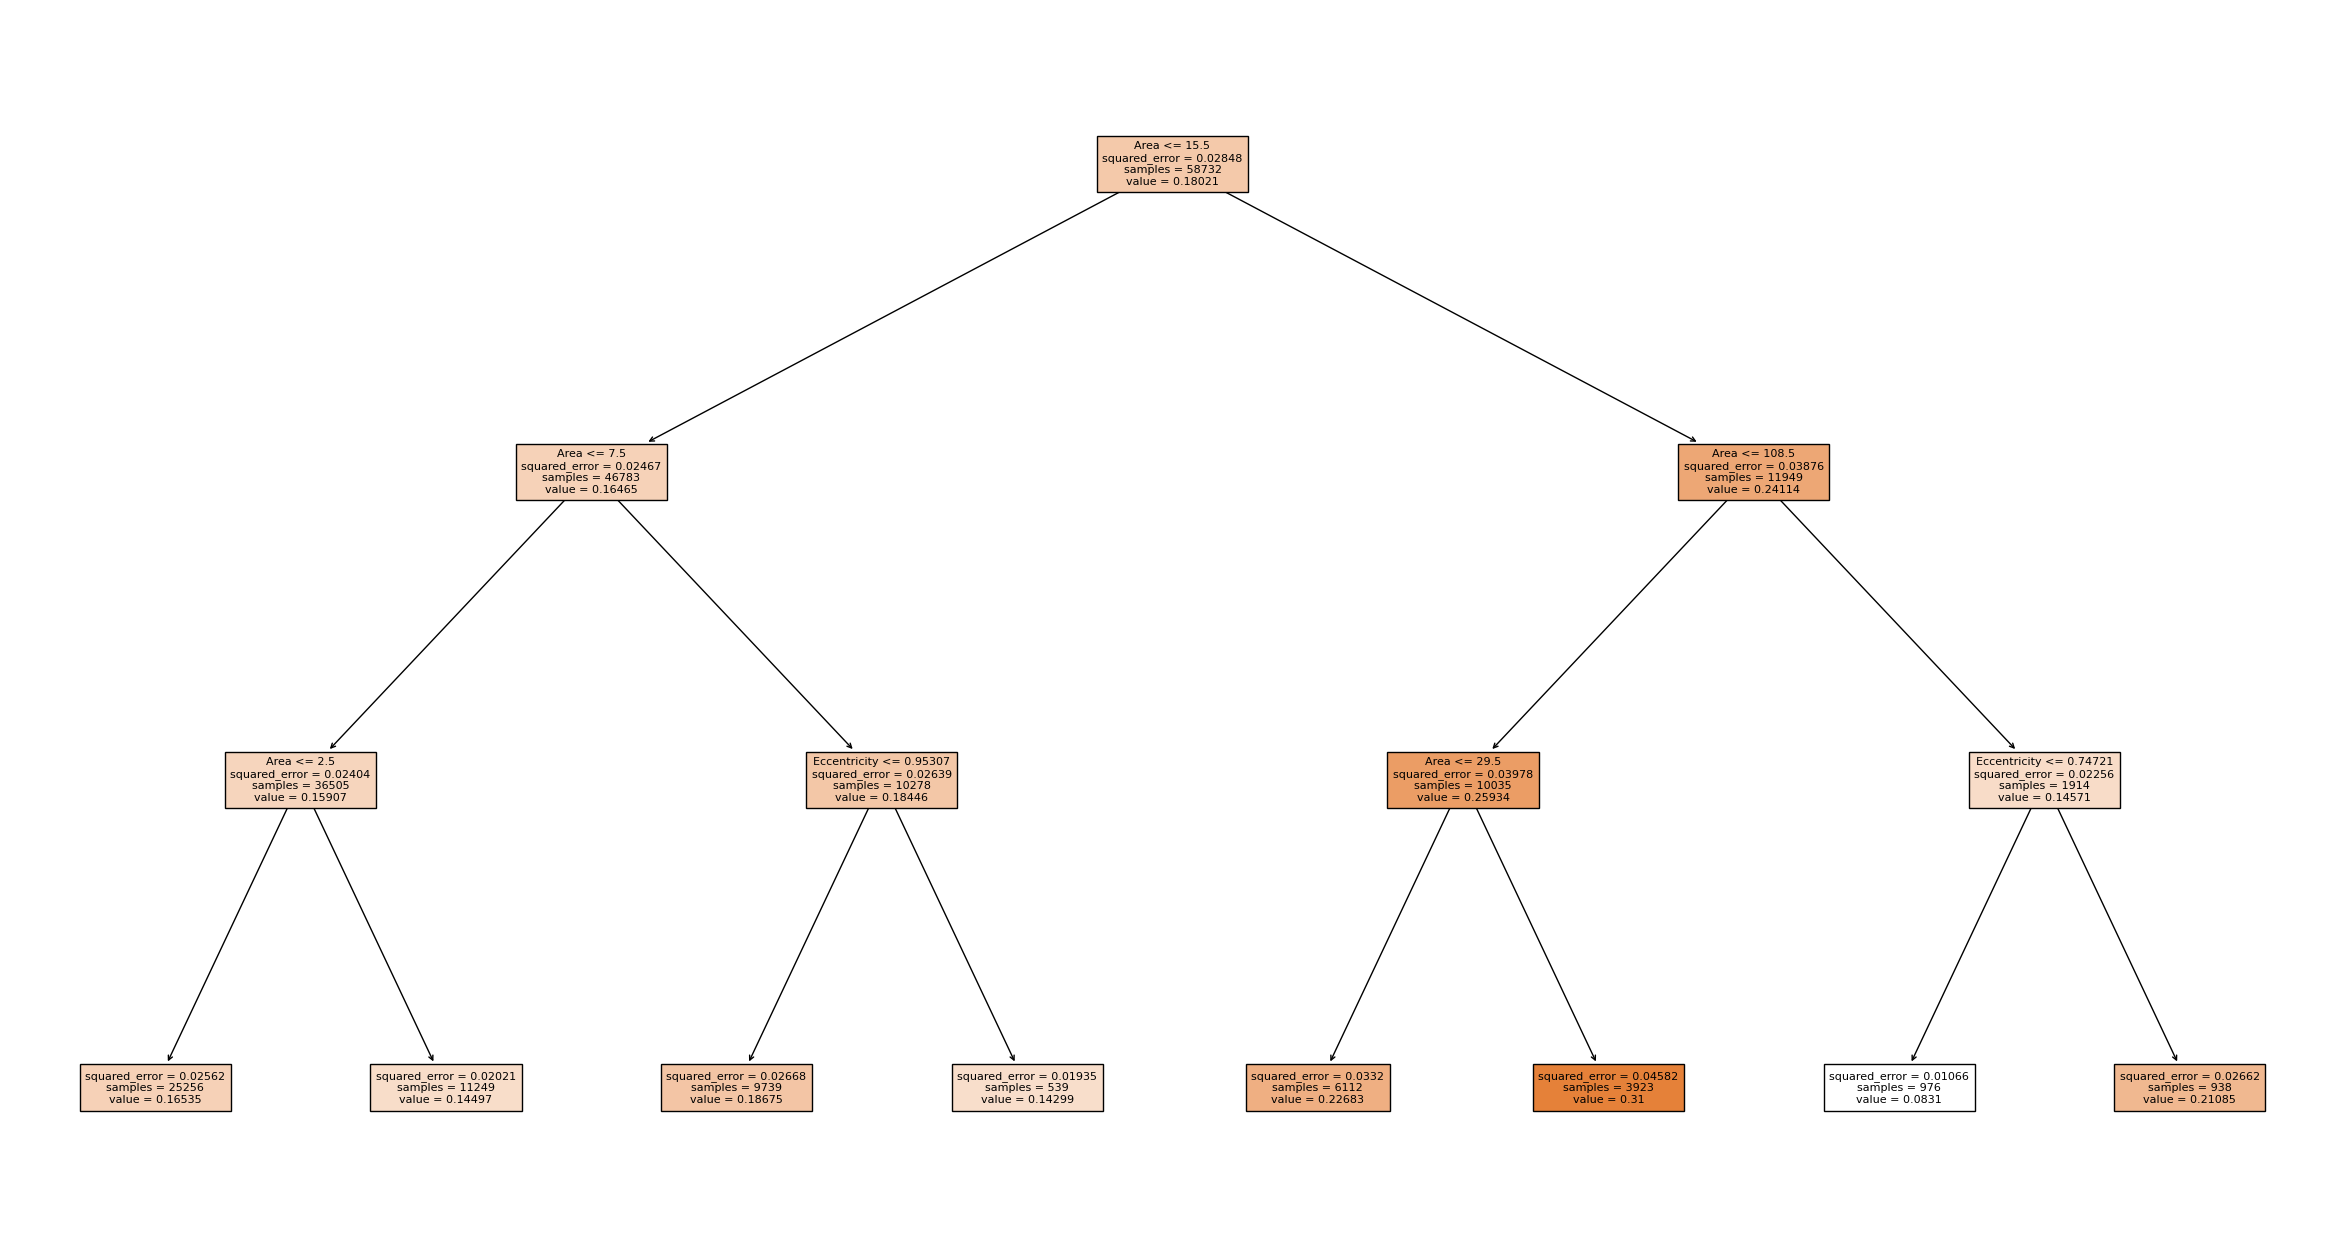

In [69]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,16))
plot_tree(regressor, max_depth=3, feature_names=['Eccentricity', 'Area'], filled=True, fontsize=8, precision=5)
plt.show()
